In [5]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Non-linear pendulum

## $$
\begin{aligned}
  \dot{q} &= \frac{p}{m l^{2}}\\
  \dot{p} &= - m l g \sin(q)\\
\end{aligned}
$$


In [6]:
function H(du, u, p, t)
    m, l, g = p
    du[1] = u[2]/(m*l^(2))
    du[2] = -m*l*g*sin(u[1])
end


# Define the experimental parameter

tspan = (0.0f0, 1.5f0)
u0 = Float32[-2., 0.]
p_ = Float32[1., 1., 9.8,]

prob = ODEProblem(H, u0, tspan, p_)

saveat = 0.03

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = saveat)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training data

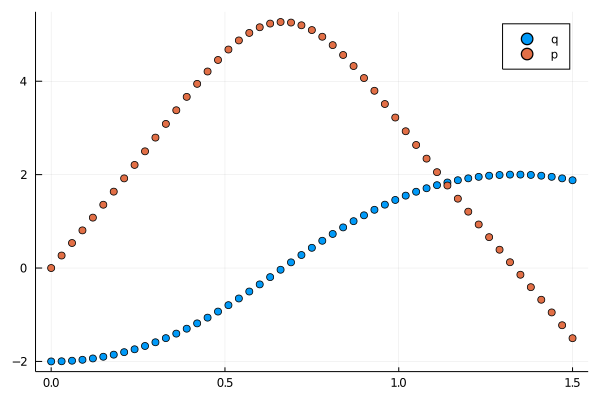

In [7]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
scatter(solution.t, Xₙ[1, :], label = "q")
scatter!(solution.t, Xₙ[2, :], label = "p")

## In the phase space

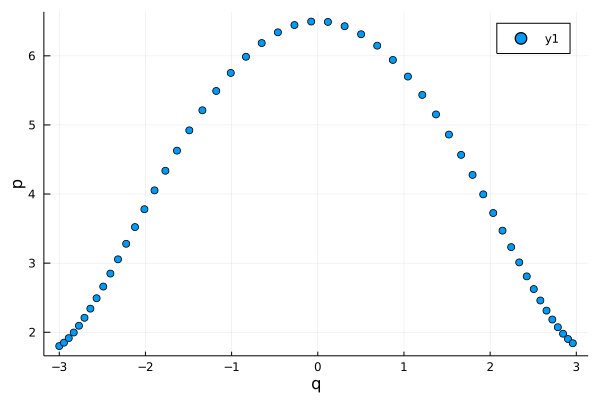

In [310]:
scatter(Array(solution)[1, :], Array(solution)[2, :], xlabel = "q", ylabel = "p")

## UADE

In [8]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2)) #|> gpu
p = initial_params(L)


# ODE
function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [z[1],
    z[2]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = solution.t);

## Plot the untrained solution

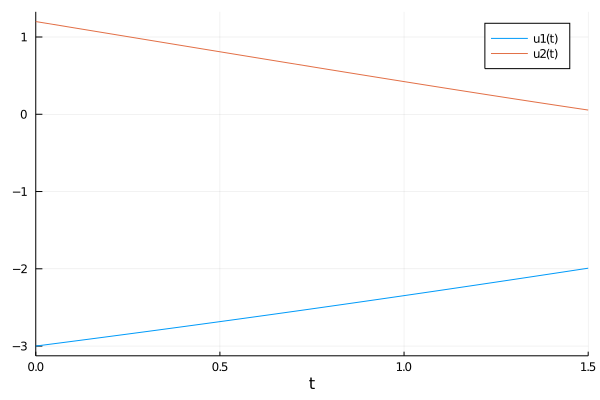

In [287]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [9]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [10]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 400)

loss: 159:   2%|██                                      |  ETA: 0:07:02

Current loss after 10 iterations: 158.8803


loss: 25.6:   5%|██                                     |  ETA: 0:06:39

Current loss after 20 iterations: 25.647364


loss: 5.32:   8%|███                                    |  ETA: 0:06:17

Current loss after 30 iterations: 5.318886


loss: 3.57:  10%|████                                   |  ETA: 0:06:06

Current loss after 40 iterations: 3.571253


loss: 2.33:  12%|█████                                  |  ETA: 0:05:49

Current loss after 50 iterations: 2.33078


loss: 1.37:  15%|██████                                 |  ETA: 0:05:23

Current loss after 60 iterations: 1.3663172


loss: 0.986:  18%|███████                               |  ETA: 0:05:01

Current loss after 70 iterations: 0.98552


loss: 0.772:  20%|████████                              |  ETA: 0:04:40

Current loss after 80 iterations: 0.7723541


loss: 0.614:  22%|█████████                             |  ETA: 0:04:24

Current loss after 90 iterations: 0.6136614


loss: 0.52:  25%|██████████                             |  ETA: 0:04:10

Current loss after 100 iterations: 0.51981866


loss: 0.46:  28%|███████████                            |  ETA: 0:03:55

Current loss after 110 iterations: 0.4596682


loss: 0.492:  30%|████████████                          |  ETA: 0:03:45

Current loss after 120 iterations: 0.49228078


loss: 0.922:  32%|█████████████                         |  ETA: 0:03:39

Current loss after 130 iterations: 0.9217572


loss: 0.792:  35%|██████████████                        |  ETA: 0:03:34

Current loss after 140 iterations: 0.7915341


loss: 0.433:  38%|███████████████                       |  ETA: 0:03:26

Current loss after 150 iterations: 0.43284017


loss: 0.417:  40%|████████████████                      |  ETA: 0:03:16

Current loss after 160 iterations: 0.41666055


loss: 0.355:  42%|█████████████████                     |  ETA: 0:03:07

Current loss after 170 iterations: 0.35512197


loss: 0.344:  45%|██████████████████                    |  ETA: 0:02:56

Current loss after 180 iterations: 0.3440487


loss: 0.332:  48%|███████████████████                   |  ETA: 0:02:46

Current loss after 190 iterations: 0.33172774


loss: 0.324:  50%|████████████████████                  |  ETA: 0:02:35

Current loss after 200 iterations: 0.32387534


loss: 0.314:  52%|████████████████████                  |  ETA: 0:02:25

Current loss after 210 iterations: 0.31369638


loss: 0.306:  55%|█████████████████████                 |  ETA: 0:02:15

Current loss after 220 iterations: 0.30636466


loss: 0.754:  58%|██████████████████████                |  ETA: 0:02:07

Current loss after 230 iterations: 0.7542632


loss: 0.629:  60%|███████████████████████               |  ETA: 0:02:01

Current loss after 240 iterations: 0.6286032


loss: 0.371:  62%|████████████████████████              |  ETA: 0:01:53

Current loss after 250 iterations: 0.3705548


loss: 0.439:  65%|█████████████████████████             |  ETA: 0:01:45

Current loss after 260 iterations: 0.43883878


loss: 0.444:  68%|██████████████████████████            |  ETA: 0:01:38

Current loss after 270 iterations: 0.44382742


loss: 0.319:  70%|███████████████████████████           |  ETA: 0:01:30

Current loss after 280 iterations: 0.319488


loss: 0.28:  72%|█████████████████████████████          |  ETA: 0:01:21

Current loss after 290 iterations: 0.27967614


loss: 0.26:  75%|██████████████████████████████         |  ETA: 0:01:13

Current loss after 300 iterations: 0.25966024


loss: 0.245:  78%|██████████████████████████████        |  ETA: 0:01:05

Current loss after 310 iterations: 0.24539575


loss: 0.238:  80%|███████████████████████████████       |  ETA: 0:00:57

Current loss after 320 iterations: 0.2382054


loss: 0.23:  82%|█████████████████████████████████      |  ETA: 0:00:50

Current loss after 330 iterations: 0.23010841


loss: 0.223:  85%|█████████████████████████████████     |  ETA: 0:00:42

Current loss after 340 iterations: 0.22288309


loss: 0.216:  88%|██████████████████████████████████    |  ETA: 0:00:35

Current loss after 350 iterations: 0.21560304


loss: 0.208:  90%|███████████████████████████████████   |  ETA: 0:00:28

Current loss after 360 iterations: 0.20841542


loss: 0.201:  92%|████████████████████████████████████  |  ETA: 0:00:21

Current loss after 370 iterations: 0.2013556


loss: 0.194:  95%|█████████████████████████████████████ |  ETA: 0:00:14

Current loss after 380 iterations: 0.1944008


loss: 0.188:  98%|██████████████████████████████████████|  ETA: 0:00:07

Current loss after 390 iterations: 0.18755984


loss: 0.181: 100%|██████████████████████████████████████| Time: 0:04:30


Current loss after 400 iterations: 0.18085411


 * Status: success

 * Candidate solution
    Final objective value:     1.808541e-01

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   327  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


## Training with BFGS

In [291]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 50)

Current loss after 410 iterations: 0.07533716


 * Status: failure

 * Candidate solution
    Final objective value:     4.803458e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 3.68e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.74e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.50e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.21e-02 ≰ 0.0e+00
    |g(x)|                 = 1.66e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    15
    f(x) calls:    51
    ∇f(x) calls:   51


## Plot the loss

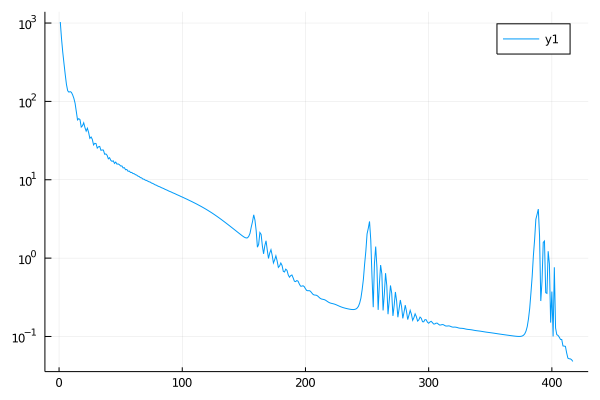

In [292]:
plot(losses, yaxis=:log)

## Plot the prediction

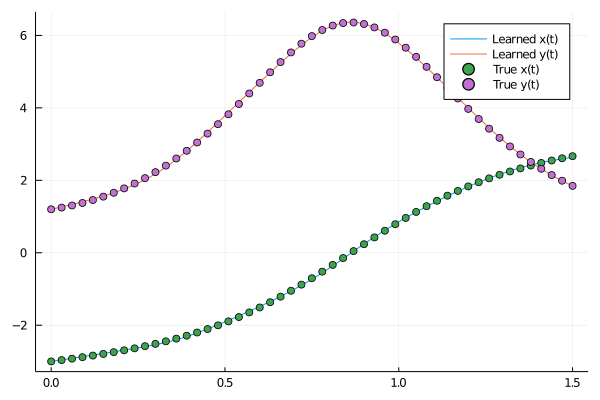

In [293]:
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [294]:
function dudt_2(u, p, t)
    x, y = u
    z = L(u, p)
    [z[1],
    z[2]]
end

# ODE problem
tspan2 = (0.0f0, 6.0f0)
prob_nn2 = ODEProblem(dudt_2, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = saveat);

## Test the prediction

In [295]:
prob_test = ODEProblem(H, u0, tspan2, p_)
solution_test = solve(prob_test, Vern7(), saveat = saveat);

## Prot together true and prediction

### Phase space

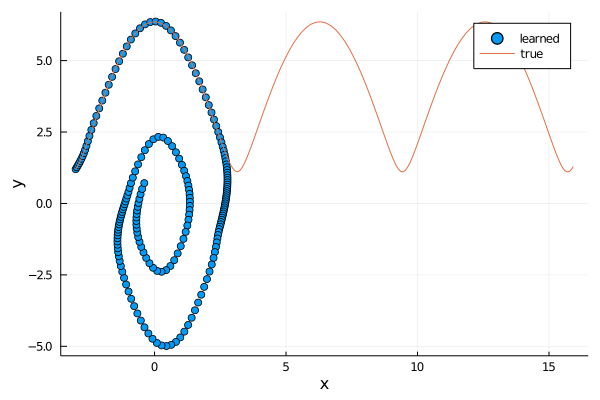

In [296]:
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], xlabel = "x", ylabel = "y", label = "learned")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "true")

## Plot $q(t)$ and $p(t)$

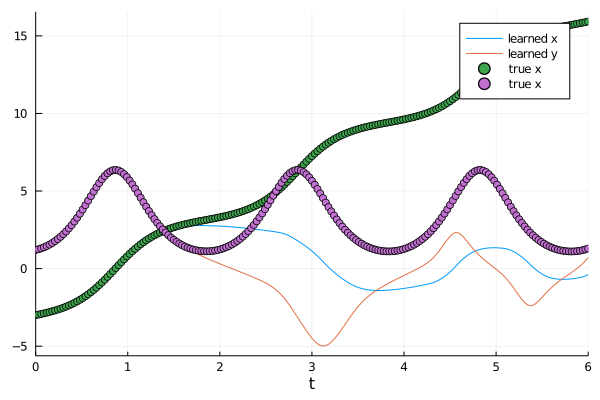

In [297]:
plot(sol_nn2, label = ["learned x" "learned y"])
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true x")

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives:
### we take derivatives with respect to $t$ of $(x(t), y(t))$ both from the known solution and the solution to the trained UADE

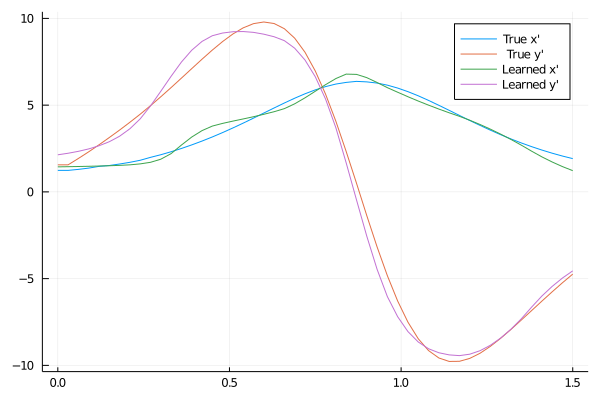

In [298]:
DX = Array(solution(solution.t, Val{1})) 

prob_nn2 = ODEProblem(dudt_2, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())

DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

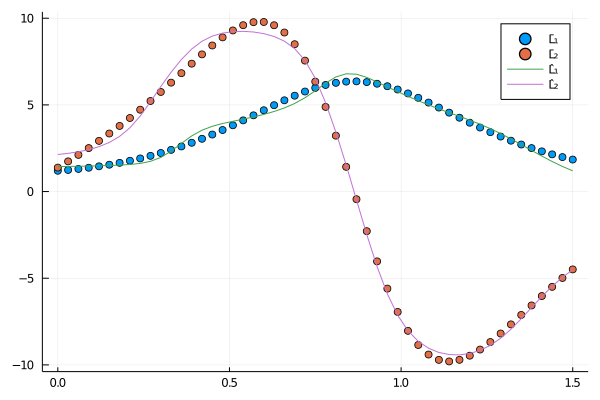

In [299]:
# Ideal data
L̄ = [(Xₙ[2,:]/(p_[1]*p_[2]^(2)))'; -p_[1]*p_[2]*p_[3]*sin.(Xₙ[1,:]')]

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄', label = ["L̄₁" "L̄₂"])
plot!(solution.t, L̂', label = ["L̂₁" "L̂₂"])


#savefig("UADE.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [300]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the algorithm

In [301]:
opt = SR3() 
#opt = STRRidge(0.1)


# Create the thresholds which should be used in the search process
λ = exp10.(-5:0.1:5)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

#Suggestion from AlCap23
#g(x) = x[1] < 1 ? Inf : norm([0.1; 10.0] .* x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [231]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 7.604627
   Equation 1 : 2.2014961
   Equation 2 : 5.403131
AICC :
   Equation 1 : -0.906549
   Equation 2 : -4.4979143

SR3{Float64,UnionAll}(0.5, 1.0, ProximalOperators.NormL1) converged after 8691 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₂
du₂ = sin(u₁) * p₂



## Test on UADE derivative data

In [302]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 50000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 5
Active terms : 5
   Equation 1 : 2
   Equation 2 : 3
Overall error (L2-Norm) : 6.4408255
   Equation 1 : 4.114174
   Equation 2 : 2.3266513
AICC :
   Equation 1 : -1.1360129
   Equation 2 : 3.5111687

SR3{Float64,UnionAll}(0.5, 1.0, ProximalOperators.NormL1) converged after 3389 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = u₂ ^ 5 * p₂ + p₁ * u₂
du₂ = sin(u₁) * p₄ + cos(u₂) * p₃ + u₁ ^ 3 * u₂ ^ 5 * p₅



## Extract the parameters

In [252]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[0.9065209, 3.5874273f-5, -8.680264, -0.13106357]


## Define the ODE with the new identified unknown term

In [279]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [280]:
function dudt(du, u, p, t)
    p1, p2, p3, p4 = p
    z = unknown_eq(u, [p1; p2; p3; p4], t)
    du[1] = z[1]
    du[2] = z[2]
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

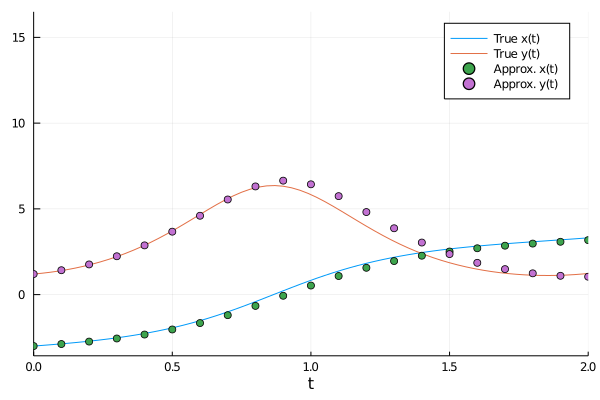

In [285]:
#ps = [p_[[1,2]]; p̂]
tspan = (0.0f0, 3.0f0)
approximate_prob = ODEProblem(dudt, u0, (0.0f0, 2.0f0), p̂)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.1)

# Plot
plot(solution_test, label = ["True x(t)" "True y(t)"])
scatter!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])

## Plot the sparse regression and the trained UA

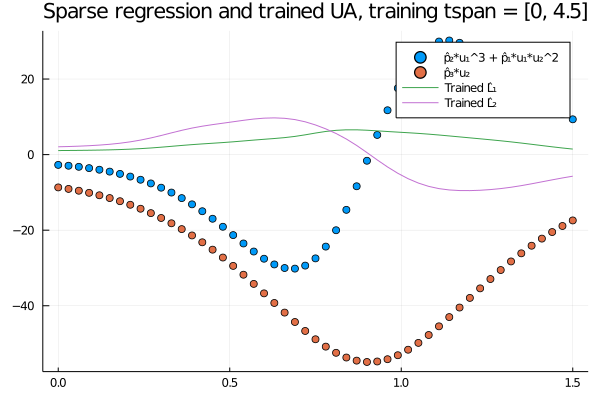

In [257]:
# Ideal data
L̄ = [(p̂[2]*Xₙ[1,:].^(3) + p̂[1]*Xₙ[1,:].*Xₙ[2,:].^(2))'; p̂[3]*Xₙ[2,:]']

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄', label = ["p̂₂*u₁^3 + p̂₁*u₁*u₂^2" "p̂₃*u₂"], title = "Sparse regression and trained UA, training tspan = [0, 4.5]")
plot!(solution.t, L̂', label = ["Trained L̂₁" "Trained L̂₂"])


#savefig("SparseAndUADE_045.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)